# Домашнее задание: модели классификации и оценка их качества.

Будем тренироваться обучать модели классификации и интерпретировать их качество.

Максимальный балл за задание - 11.
Балл, который ставится в ведомость - min(10,ваш балл).

## Часть 1. Обучение моделей классификации (5 баллов). 

Поработайте с датасетом telecom_churn. Вам предстоит по характеристикам клиента предсказать, уйдет он или нет (целевая колонка - Churn).

A. Решите задачу с помощью логистической регрессии:
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

B. Решите задачу с помощью метода опорных векторов (с kernel = 'linear'):
- подберите значение гиперпараметров с помощью GridSearchCV
Что вы можете сказать об алгоритме? Он переобучился/недообучился/обучился как надо и вы довольны качеством?

Не забудьте масштабировать данные перед применением линейных моделей.

C. Попробуйте увеличить число признаков с помощью добавления полиномиальных признаков. Также можно добавить функции от признаков вручную (те, которые вам кажутся подходящими в данной задаче).
Улучшилось ли качество алгоритма?

D. Постройте матрицу корреляций признаков. Есть ли признаки, которые практически не коррелируют с целевой переменной? Попробуйте их удалить. Есть ли пары сильно коррелирующих между собой признаков? Удалите по одному признаку из каждой пары.
Помогло ли это улучшить качество в данной задаче?

Пункты C и D можно скомбинировать для достижения наилучшего качества.

E. Сделайте мини-отчет о проведенной работе. Для этого ответьте на вопросы:
a) какой классификатор дал наилучший результат? чему равны значения метрик accuracy, f1-score и ROC-AUC? 
(Вы можете изначально разбить данные на train и test и сравнивать значения метрик на этих выборках; или же можно оценивать качество алгоритмов по кросс-валидации).

b) какие новые признаки вы добавили и какие признаки удалили?

c) удалось ли добиться того, что алгоритм не переобучился и не недообучился?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder

#%pylab inline

In [2]:
# Выгружаем dataframe
df = pd.read_csv('telecom_churn.csv')

In [3]:
df.shape

(3333, 20)

In [4]:
# Создаем копию чтобы не трогать с исходник
df_c = df.copy()

In [5]:
# Целевая переменная имеет значения [True, False], конвертируем в [1,0]
df_c.Churn = df_c.Churn.map(int)

In [6]:
df_c[:5]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [7]:
# Проверим на дисбаланс классов
df_c.Churn.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

Как видно у нас имеется дисбаланс классов. Объектов класса 1 ~15%

In [8]:
# Посмотрим какие нечисловые переменные есть в наших данных
df_c.describe(include='object')

,State,International plan,Voice mail plan
count,3333,3333,3333
unique,51,2,2
top,WV,No,No
freq,106,3010,2411


In [9]:
# И проверим заполняемость наших признаков
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [10]:
#df_obj = df_c.select_dtypes(include='object')
#df_numeric = df_c.select_dtypes(exclude='object')

In [11]:
#df_obj[:5]

In [12]:
df_c['Voice mail plan'].value_counts(), df_c['International plan'].value_counts()

(No     2411
 Yes     922
 Name: Voice mail plan, dtype: int64,
 No     3010
 Yes     323
 Name: International plan, dtype: int64)

Поля **Voice mail plan** и **International plan** имеют бинарную структуру значений, поэтому конвертируем значения в [0,1]

In [13]:
df_c['Voice mail plan'] = df_c.loc[:, 'Voice mail plan'].map({'No':0, 'Yes':1})
df_c['International plan'] = df_c.loc[:, 'International plan'].map({'No':0, 'Yes':1})

In [14]:
# Разделим признаки и целевую переменную
X_ = df_c.drop(columns='Churn')
y = df_c.loc[:, 'Churn']

In [15]:
# Разделим датасет на тестовую и тренироввочную выгрузки
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

In [16]:
# Для тренировочной выборки посмотрим 'встречаемость' каждого штата, так как планирую делать target encoding
X_train.loc[:, 'State'].value_counts()[0],\
X_train.loc[:, 'State'].value_counts()[-1]

(69, 25)

В общем и целом, на мой взгляд, разница между самым популярным и непопулярным штатом не такая уж большая и, что как мне кажется важно, даже самый непопулярный штат встречается число раз не сильно близкое к 0

In [17]:
# Инициализируем TargetEncoder
target_enc = TargetEncoder()

In [18]:
# Вычисляем параметры TargetEncoder на тренировочной выборке
target_enc.fit(X_train, y_train)

TargetEncoder(cols=['State'])

In [19]:
# Применяем encoder на Train
X_train = target_enc.transform(X_train)

In [20]:
X_train[:5]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
2016,0.088924,80,510,0,0,0,202.4,118,34.41,260.2,67,22.12,177.4,112,7.98,9.2,5,2.48,3
1362,0.101777,63,510,0,0,0,132.9,122,22.59,67.0,62,5.70,160.4,121,7.22,9.9,2,2.67,3
2670,0.125551,116,510,0,1,12,221.0,108,37.57,151.0,118,12.84,179.0,80,8.06,9.0,6,2.43,2
2210,0.111257,71,415,0,0,0,278.9,110,47.41,190.2,67,16.17,255.2,84,11.48,11.7,7,3.16,0
1846,0.156170,120,510,0,1,43,177.9,117,30.24,175.1,70,14.88,161.3,117,7.26,11.5,4,3.11,1


In [21]:
# Инициализируем StandardScaler
scaler = StandardScaler()

In [22]:
# Вычисляем параметры StandardScaler на тренировочной выборке
scaler.fit(X_train)

StandardScaler()

In [23]:
# Нормируем данные на Train
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)

In [24]:
X_train[:5]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,-1.008863,-0.511937,1.740454,-0.324289,-0.612192,-0.585483,0.410716,0.873749,0.410877,1.167102,-1.646317,1.167733,-0.456961,0.615443,-0.458282,-0.373682,0.226639,-0.379643,1.073319
1,-0.781135,-0.939002,1.740454,-0.324289,-0.612192,-0.585483,-0.864713,1.074874,-0.865095,-2.639021,-1.895351,-2.637901,-0.790790,1.075039,-0.789925,-0.122835,-0.997316,-0.127479,1.073319
2,-0.359870,0.392435,1.740454,-0.324289,1.633475,0.289180,0.752053,0.370935,0.752000,-0.984185,0.893834,-0.983076,-0.425542,-1.018675,-0.423373,-0.445353,0.634624,-0.446002,0.323378
3,-0.613162,-0.738030,-0.515843,-0.324289,-0.612192,-0.585483,1.814605,0.471498,1.814230,-0.211928,-1.646317,-0.211288,1.070799,-0.814411,1.069020,0.522200,1.042609,0.522840,-1.176504
4,0.182656,0.492921,1.740454,-0.324289,1.633475,2.548723,-0.038896,0.823467,-0.039276,-0.509404,-1.496896,-0.510269,-0.773117,0.870774,-0.772470,0.450529,-0.181346,0.456481,-0.426563


In [25]:
# Инициализируем LogisticRegression с дефолтными параметрами
model = LogisticRegression()

In [26]:
# Обучаем модель
model.fit(X_train, y_train)

LogisticRegression()

In [27]:
# Делаем предсказания на Test, предварительно применив TargetEncoder и StandardScaler, обученные на Train
pred = model.predict(pd.DataFrame(data=scaler.transform(target_enc.transform(X_test)), columns=X_test.columns))

In [28]:
# Смотрим метрики качества на Test
accuracy_score(y_test, pred)\
, precision_score(y_test, pred)\
, recall_score(y_test, pred)\
, f1_score(y_test, pred)

(0.861, 0.5333333333333333, 0.22377622377622378, 0.31527093596059114)

In [29]:
# Смотрим метрики качества на Train
accuracy_score(y_train, model.predict(X_train))\
, precision_score(y_train, model.predict(X_train))\
, recall_score(y_train, model.predict(X_train))\
, f1_score(y_train, model.predict(X_train))

(0.8709815687955422,
 0.6308724832214765,
 0.27647058823529413,
 0.3844580777096115)

### Оформим pipeline и подберем гиперпараметры

In [30]:
df_c = df.copy()

In [31]:
df_c['Voice mail plan'] = df_c.loc[:, 'Voice mail plan'].map({'No':0, 'Yes':1})
df_c['International plan'] = df_c.loc[:, 'International plan'].map({'No':0, 'Yes':1})

In [32]:
X_ = df_c.drop(columns='Churn')
y = df_c.loc[:, 'Churn']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

In [34]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000))
])

В качетсве парметров для подбора, пробовал **smoothing** у TargetEncoder, **C**, **solver** у LogisticRegression
По итогу получил такие лучшие парметры из диапазонов подбора: **smothing=16**, **C=3.5**, **solver='newton-cg'**

In [35]:
param_grid = dict(target_encoder__smoothing=np.arange(1, 30, 5),
                  model__C=np.arange(0.5, 8, 0.5)
                  )

In [36]:
# Создаем GridSearchCV для подбора параметров по f1_score 
# Ниже я написал почему считаю что accuracy в данном случаее, на мой взгляд, менее показательный
gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1')

In [37]:
gs.fit(X_, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('target_encoder',
                                        TargetEncoder(cols='State')),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'model__C': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5]),
                         'target_encoder__smoothing': array([ 1,  6, 11, 16, 21, 26])},
             scoring='f1')

In [38]:
print('best_score:', gs.best_score_)
print('best params:', gs.best_params_)

best_score: 0.3277801939041532
best params: {'model__C': 3.5, 'target_encoder__smoothing': 16}


In [39]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('target_encoder', TargetEncoder(cols=['State'])),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=5000))])

In [40]:
pred = pipe.predict(X_test)

In [41]:
accuracy_score(y_test, pred)\
, precision_score(y_test, pred)\
, recall_score(y_test, pred)\
, f1_score(y_test, pred)

(0.861, 0.5333333333333333, 0.22377622377622378, 0.31527093596059114)

In [42]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State', smoothing=16)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='newton-cg', C=3.5))
])

In [43]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('target_encoder', TargetEncoder(cols=['State'], smoothing=16)),
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=3.5, solver='newton-cg'))])

In [44]:
pred = pipe.predict(X_test)

In [45]:
accuracy_score(y_test, pred)\
, precision_score(y_test, pred)\
, recall_score(y_test, pred)\
, f1_score(y_test, pred)

(0.861, 0.5333333333333333, 0.22377622377622378, 0.31527093596059114)

In [46]:
cross_validate(pipe, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1'))

{'fit_time': array([0.11878228, 0.14260459, 0.11571169, 0.13316965, 0.12543845]),
 'score_time': array([0.01664162, 0.00405407, 0.00836611, 0.01262283, 0.01117396]),
 'test_accuracy': array([0.85607196, 0.85907046, 0.86056972, 0.86186186, 0.86786787]),
 'test_precision': array([0.51162791, 0.53658537, 0.54545455, 0.55555556, 0.5952381 ]),
 'test_recall': array([0.22680412, 0.22680412, 0.24742268, 0.20833333, 0.26041667]),
 'test_f1': array([0.31428571, 0.31884058, 0.34042553, 0.3030303 , 0.36231884])}

Как видно, на тестовых данных качество не изменилось никак 

**Выводы:** \
Нам необходимо было предсказать уйдет клиент или нет. Возможно наша цель была разметить клиентов которые намерены уйти и предложить им специальные условия или мы хотели разметить их чтобы именно им их не предлагать так как они уйдут. 
В 1 случае нам желательно иметь небольшой FP, так как предлагать скидки тем, кто и без них будет нашим клиентом затратно. Во втором случае ситуация такая, что спецпредложение - штатная ситуация и нам не хочется давать ее клиенту который все равно уйдет. Тода нам для максимизации прибыли необходимо иметь наибольшую полноту, т.е. мало FN (прямой эффект) и, при этом нам снова нельзя много ошибаться так как если акция - штатная ситуация, то  не дав ее 'устойчивому клиенту' он может уйти. Итого, на мой взгляд, нам нужен хороший баланс Precision и Recall или f1_score при дисбалансе классов. (класс 1 ~16%)
Вполне возможно что цель  была другая, например, понять какими характеристиками обладает наш 'устойчивый' клиент (так как данные пользовательствие, то он, скорее всего, должен быть уже клиентом конкурента), чтобы направить на таких рекламные акции.

На мой взгляд, задача решена неуспешно. Полнота порядка 20% и точность около 50%. f1 на уровне 31%. Параметов я перебрал немного (C, solver и smoothing у TargetEncoder), но с вариациями этих параметров значительного улучшения качества достигнуть не удалось.
Может быть в данном случае как раз помогло изменение порога разметки класса. 
Модель не переобучилась, она скорее не дообучилась так как на Train метрики качества отличаются незначительно

### SVC

Проделаем такие же операции, но будем использовать в качестве модели **SVC** с **kernel='linear'**

In [47]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State')),
    ('scaler', StandardScaler()),
    ('model', SVC(kernel = 'linear'))
])

In [48]:
cross_validate(pipe, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1'))

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

{'fit_time': array([0.32327318, 0.35927701, 0.34317207, 0.34029508, 2.01012993]),
 'score_time': array([0.05792403, 0.05407572, 0.0506227 , 0.05145526, 0.05750179]),
 'test_accuracy': array([0.85457271, 0.85457271, 0.85457271, 0.85585586, 0.85585586]),
 'test_precision': array([0., 0., 0., 0., 0.]),
 'test_recall': array([0., 0., 0., 0., 0.]),
 'test_f1': array([0., 0., 0., 0., 0.])}

In [49]:
df_c = df.copy()
df_c.Churn = df_c.Churn.map(int)
df_c['Voice mail plan'] = df_c.loc[:, 'Voice mail plan'].map({'No':0, 'Yes':1})
df_c['International plan'] = df_c.loc[:, 'International plan'].map({'No':0, 'Yes':1})
X_ = df_c.drop(columns='Churn')
y = df_c.loc[:, 'Churn']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

In [51]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('target_encoder', TargetEncoder(cols=['State'])),
                ('scaler', StandardScaler()), ('model', SVC(kernel='linear'))])

In [52]:
pred = pipe.predict(X_test)

In [53]:
np.unique(pred, return_counts=True)

(array([0], dtype=int64), array([1000], dtype=int64))

Как видим, SVC с kernel='linear' разметил всех пользователей классом 0

In [54]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State')),
    ('scaler', StandardScaler()),
    ('model', SVC(kernel ='rbf'))
])

In [55]:
cross_validate(pipe, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1'))

{'fit_time': array([0.29301262, 0.26315141, 0.27325273, 0.27748513, 0.27830815]),
 'score_time': array([0.12361836, 0.12517214, 0.12002516, 0.12123609, 0.12600756]),
 'test_accuracy': array([0.91154423, 0.91004498, 0.92953523, 0.90990991, 0.91891892]),
 'test_precision': array([0.88      , 0.83636364, 0.91666667, 0.89130435, 0.86206897]),
 'test_recall': array([0.45360825, 0.4742268 , 0.56701031, 0.42708333, 0.52083333]),
 'test_f1': array([0.59863946, 0.60526316, 0.70063694, 0.57746479, 0.64935065])}

In [56]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('target_encoder', TargetEncoder(cols=['State'])),
                ('scaler', StandardScaler()), ('model', SVC())])

In [57]:
pred = pipe.predict(X_test)

In [58]:
np.unique(pred, return_counts=True)

(array([0, 1], dtype=int64), array([925,  75], dtype=int64))

**SVC** с kernel='rbf' справился намного лучше

### Подбор гиперпараметров SVC

Мы увидели что SVC может сильно лучше справиться с задаче, попробуем его еще немного докрутить, подобрав гиперпараметры

In [59]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State')),
    ('scaler', StandardScaler()),
    ('model', SVC())
])

In [60]:
param_grid = dict(model__kernel=['linear', 'poly', 'rbf', 'sigmoid'],
                  model__C=np.arange(0.5,6,0.5)
                 )

In [61]:
gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1')

In [62]:
gs.fit(X_, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('target_encoder',
                                        TargetEncoder(cols='State')),
                                       ('scaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid={'model__C': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [63]:
print('best_score:', gs.best_score_)
print('best params:', gs.best_params_)

best_score: 0.6891801348355525
best params: {'model__C': 4.5, 'model__kernel': 'rbf'}


Качество по f1_score в сравнении с LogisticRegression() удалось улучшить более чем в 2 раза (f1_score для LogisticRegression было ~0.31)

In [64]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State', smoothing=16)),
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', C=4.5))
])

In [65]:
cross_validate(pipe, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1'))

{'fit_time': array([0.33521867, 0.29784346, 0.30809259, 0.30593824, 0.29166055]),
 'score_time': array([0.12213516, 0.11269927, 0.12102437, 0.11554837, 0.12398696]),
 'test_accuracy': array([0.91154423, 0.91904048, 0.93403298, 0.91741742, 0.92642643]),
 'test_precision': array([0.78787879, 0.79452055, 0.84415584, 0.81538462, 0.84057971]),
 'test_recall': array([0.53608247, 0.59793814, 0.67010309, 0.55208333, 0.60416667]),
 'test_f1': array([0.63803681, 0.68235294, 0.74712644, 0.65838509, 0.7030303 ])}

Подбор гиперпарметров дал значительный результат

### Проверка на мультикорреляции

In [66]:
train_data = pd.concat([X_train, pd.DataFrame(data=y_train, columns=['Churn']).reset_index(drop=True)], axis=1)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

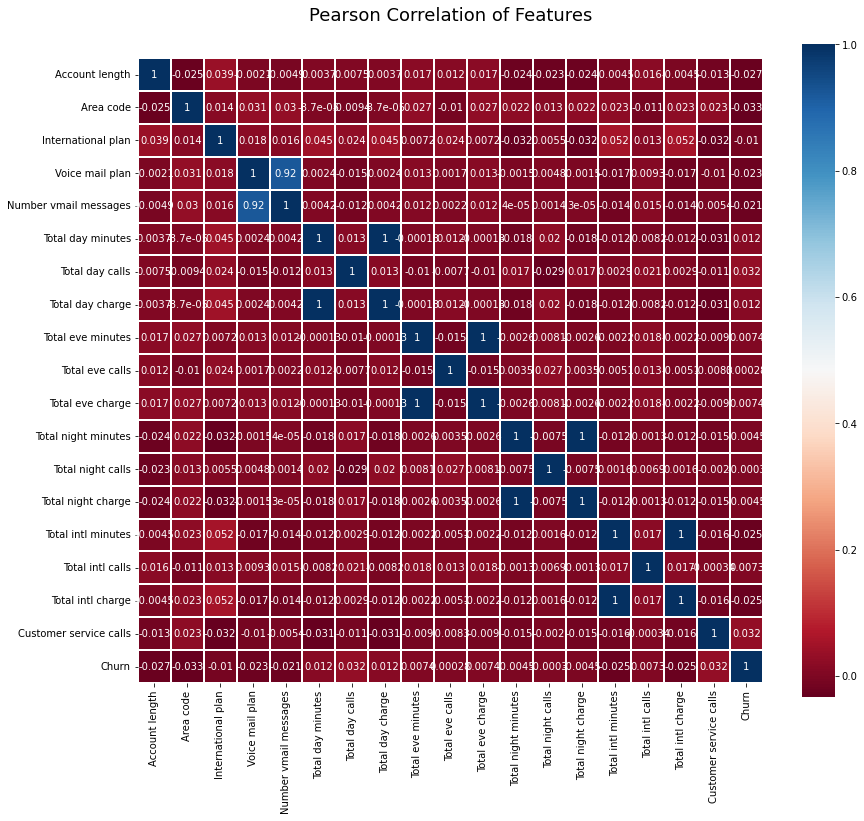

In [67]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))

plt.title('Pearson Correlation of Features', y=1.05, size=18)
sns.heatmap(train_data.corr('kendall'),
            linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [68]:
train_data.corr('kendall').loc[:, 'Churn'].apply(abs).sort_values()

Total eve calls           0.000277
Total night calls         0.000302
Total night charge        0.004466
Total night minutes       0.004482
Total intl calls          0.007301
Total eve charge          0.007358
Total eve minutes         0.007377
International plan        0.010255
Total day minutes         0.012411
Total day charge          0.012411
Number vmail messages     0.021011
Voice mail plan           0.023128
Total intl charge         0.025188
Total intl minutes        0.025188
Account length            0.027391
Total day calls           0.031710
Customer service calls    0.031717
Area code                 0.032739
Churn                     1.000000
Name: Churn, dtype: float64

По данным корреляции мы видим: \
    **1.** У нас есть _minutes и _charge, которые дублируют информацию \
    **2.** Есть признаки, значение корреляции с целевой метрикой которых ненулевое только поле 3 знака после запятой \
Попробуем удалить такие признаки

In [69]:
# Создадим список полей для удаления
cols_for_del = [i for i in train_data.columns if 'charge' in i]
cols_for_del.append('Total day calls')
cols_for_del.append('Total eve calls')
cols_for_del.append('Total night calls')

In [70]:
cols_for_del

['Total day charge',
 'Total eve charge',
 'Total night charge',
 'Total intl charge',
 'Total day calls',
 'Total eve calls',
 'Total night calls']

In [71]:
df_c = df.copy()
df_c.Churn = df_c.Churn.map(int)
df_c['Voice mail plan'] = df_c.loc[:, 'Voice mail plan'].map({'No':0, 'Yes':1})
df_c['International plan'] = df_c.loc[:, 'International plan'].map({'No':0, 'Yes':1})
df_c.drop(columns=cols_for_del, inplace=True)
X_ = df_c.drop(columns='Churn')
y = df_c.loc[:, 'Churn']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

In [73]:
X_train.shape

(2333, 12)

In [74]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State', smoothing=16)),
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', C=4.5))
])

In [75]:
cross_validate(pipe, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1'))['test_f1'].mean()

0.7302308275668103

**--** Как видно, нам удалось улучшить качество по сравнению с применеием SVC к исходному датафрейму удалением фичей с мультикорреляцией и с самыми маленькими значениями корреляции с целевой переменной \
**--** Тперь попробуем сгенерировать новые признаки

In [76]:
pipe = Pipeline([
    ('target_encoder', TargetEncoder(cols='State', smoothing=16)),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('model', SVC(kernel='rbf', C=4.5))
])

In [77]:
cross_validate(pipe, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1'))['test_f1'].mean()

0.7296164362478121

Простое применение PolynomialFeatures немного ухудшило качество. Попробуем взять самые значимые признаки, при этом имеющие небольшую корреляцию между собой и перемножить их

In [78]:
df_c = df.copy()
df_c.Churn = df_c.Churn.map(int)
df_c['Voice mail plan'] = df_c.loc[:, 'Voice mail plan'].map({'No':0, 'Yes':1})
df_c['International plan'] = df_c.loc[:, 'International plan'].map({'No':0, 'Yes':1})
df_c.drop(columns=cols_for_del, inplace=True)
X_ = df_c.drop(columns='Churn', inplace=False)
y = df_c.loc[:, 'Churn']

In [79]:
# Так как мы хотим перемножить фичу State, то ее сначала нужно преобразовать
target_enc = TargetEncoder(cols='State', smoothing=16)

In [80]:
# Разделим данные на Train и Test
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

In [81]:
# Вычислим параметры TargetEncoder
target_enc.fit(X_train, y_train)

TargetEncoder(cols=['State'], smoothing=16)

In [82]:
# Применяем TArgetEncoder ко всему датасету
X_ = target_enc.transform(X_)

In [83]:
# X_.info()

In [84]:
# Генерируем новые признаки
X_['Total day minutes_x_State'] = X_.loc[:, 'Total day minutes']*X_.loc[:, 'State']
X_['Total day minutes_x_International plan'] = X_.loc[:, 'Total day minutes']*X_.loc[:, 'International plan']
X_['International plan_x_State'] = X_.loc[:, 'International plan']*X_.loc[:, 'State']

In [85]:
X_[:5]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total eve minutes,Total night minutes,Total intl minutes,Total intl calls,Customer service calls,Total day minutes_x_State,Total day minutes_x_International plan,International plan_x_State
0,0.184347,128,415,0,1,25,265.1,197.4,244.7,10.0,3,1,48.870363,0.0,0.000000
1,0.138595,107,415,0,1,26,161.6,195.5,254.4,13.7,3,1,22.396977,0.0,0.000000
2,0.248526,137,415,0,0,0,243.4,121.2,162.6,12.2,5,0,60.491222,0.0,0.000000
3,0.138595,84,408,1,0,0,299.4,61.9,196.9,6.6,7,2,41.495389,299.4,0.138595
4,0.143438,75,415,1,0,0,166.7,148.3,186.9,10.1,3,3,23.911107,166.7,0.143438


In [86]:
X_train = X_.iloc[X_train.index]

In [87]:
X_train[:5]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total eve minutes,Total night minutes,Total intl minutes,Total intl calls,Customer service calls,Total day minutes_x_State,Total day minutes_x_International plan,International plan_x_State
2016,0.094571,80,510,0,0,0,202.4,260.2,177.4,9.2,5,3,19.141135,0.0,0.0
1362,0.103428,63,510,0,0,0,132.9,67.0,160.4,9.9,2,3,13.745582,0.0,0.0
2670,0.126977,116,510,0,1,12,221.0,151.0,179.0,9.0,6,2,28.061935,0.0,0.0
2210,0.114789,71,415,0,0,0,278.9,190.2,255.2,11.7,7,0,32.014722,0.0,0.0
1846,0.154915,120,510,0,1,43,177.9,175.1,161.3,11.5,4,1,27.559306,0.0,0.0


In [88]:
scaler = StandardScaler()

In [89]:
scaler.fit(X_train)

StandardScaler()

In [90]:
X_ = pd.DataFrame(data=scaler.transform(X_), columns=X_.columns)

In [91]:
X_[:5]

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total eve minutes,Total night minutes,Total intl minutes,Total intl calls,Customer service calls,Total day minutes_x_State,Total day minutes_x_International plan,International plan_x_State
0,0.754639,0.693893,-0.515843,-0.324289,1.633475,1.236730,1.561355,-0.070085,0.864611,-0.087000,-0.589331,-0.426563,1.727727,-0.308001,-0.304295
1,-0.142125,0.166342,-0.515843,-0.324289,1.633475,1.309619,-0.338025,-0.107516,1.055090,1.238905,-0.589331,-0.426563,-0.307824,-0.308001,-0.304295
2,2.012592,0.919986,-0.515843,-0.324289,-0.612192,-0.585483,1.163127,-1.571257,-0.747589,0.701376,0.226639,-1.176504,2.621260,-0.308001,-0.304295
3,-0.142125,-0.411451,-0.682096,3.083668,-0.612192,-0.585483,2.190811,-2.739493,-0.074039,-1.305399,1.042609,0.323378,1.160662,4.805139,2.677673
4,-0.047203,-0.637545,-0.515843,3.083668,-0.612192,-0.585483,-0.244433,-1.037376,-0.270409,-0.051165,-0.589331,1.073319,-0.191402,2.538894,2.781869


In [92]:
model = SVC(C=4.5, kernel='rbf')

In [93]:
cv = cross_validate(model, X_, y, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

In [94]:
cv['test_f1'].mean()\
,cv['test_accuracy'].mean()\
,cv['test_roc_auc'].mean()

(0.7424012873260718, 0.934292313302808, 0.9064359136673298)

In [95]:
model.fit(X_.loc[X_train.index], y_train)

SVC(C=4.5)

In [96]:
pred = model.predict(X_.loc[X_test.index])

In [97]:
# Метрики качества на Test
accuracy_score(y_test, pred)\
, precision_score(y_test, pred)\
, recall_score(y_test, pred)\
, f1_score(y_test, pred) \
, roc_auc_score(y_test, pred)

(0.926,
 0.8285714285714286,
 0.6083916083916084,
 0.7016129032258066,
 0.7936940539040889)

In [98]:
# Метрики качества на Train
accuracy_score(y_train, model.predict(X_.loc[X_train.index]))\
, precision_score(y_train, model.predict(X_.loc[X_train.index]))\
, recall_score(y_train, model.predict(X_.loc[X_train.index]))\
, f1_score(y_train, model.predict(X_.loc[X_train.index])) \
, roc_auc_score(y_train, model.predict(X_.loc[X_train.index]))

(0.9665666523789113,
 0.9678571428571429,
 0.7970588235294118,
 0.8741935483870968,
 0.8962715091053983)

**Выводы:** \
    - В ходе решния нашей задачи мы использовали 2 вида моделей LogisticRegression и SVC. SVC из коробки справилась с задачей сильно лучше. (SVC с kernel=linear с задачей также не справился) \
    - Мы подбирали гиперпараметры для улучшения качества моделей. Для LogisticRegression это не дало значимых результатов, в то время как для SVC удалось получить неплохое улучшение метрик
    - Мы пробовали генерировать новые фичи и удалять малозначимые признаки, признаки с мультиколлинеарностью. Простое добавление полиномиальных признаков со степенью 2 не дало результатов, даже незначительно ухудшило качество. Добавление нескольких конкретных полиномиальных признаков помогло еще немного улучшить качество
    В итоге нам удалось улучшить качество f1_score=0.327 на кросс-валидации для дефолтной LogisticRegression до f1_score=0.742 для SVC(C=4.5, kernel='rbf'). ROC-AUC для данной версии составил ~0.9 на кросс-валидации. При этом, у этой модели есть подозрения на переобучение так как на train и test метрики качества довольно сильно отличаются, хотя все еще являются высокими (но возможно непредсказуемыми).

## Часть 2. Оценка качества моделей классификации (6 баллов).

**Задание 0 (1 балл)**. Закончите определения, начинающиеся так:

    * accuracy - это доля правильных ответов по отношению ко всем ответам (кол-ву классифицируемых объектов)
    
    * точность (precision) - это доля правильных ответов ко всем объектам размеченным эти классом (TP+FP) (целевого класса в случае бинарной классификации)
    
    * полнота (recall) - это доля правильных ответов ко всем объектам, в действительности относящимся к данному классу (TP+FN) 
    
    * TPR - это доля правильных ответов ко всем объектам, в действительности относящимся к данному классу (TP+FN) 
    
    
Продолжите определения прямо в этой ячейке.

_______________________________________________________________________________________________

В этой части вы будете работать с данными в задаче скоринга. За работу с этими данными можно получить **5 баллов.**

* Колонки 0, 1, ..., 13 - анонимизированные характеристики клиентов (некоторые числовые, некоторые категориальные). 
* Target - целевая переменная: 1 - выдать кредит, 0 - не выдать кредит.

На этих данных было обучено три различных алгоритма классификации и получены предсказания:
* pred1_probs - предсказанные вероятности положительного класса, полученные алгоритмом 1.
* pred1_classes - предсказанные алгоритмом 1 классы
* pred2_probs, pred2_classes, pred3_probs, pred3_classes - аналогичные величины для алгоритмов 2 и 3

Наша задача - оценить качество каждого из трех алгоритмов и разобраться, какой из алгоритмов лучше всего работает в данной задаче.

In [99]:
df = pd.read_csv("credit_scoring_example1.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [100]:
df.shape

(689, 21)

**Задание 1.** Проверьте target на сбалансированность по классам, сделайте вывод.

In [101]:
df.target.value_counts()

0    382
1    307
Name: target, dtype: int64

Таргет можно считать сбалансированным

**Задание 2.** Вычислите accuracy - долю правильных ответов каждого из алгоритмов. Какой алгоритм имеет наибольшую accuracy?

In [102]:
# Вычисляем Accuracy для каждого из алгоритмов
for i in range(1,4):
    pred_col = 'pred'+str(i)+'_classes'
    pred = df[pred_col]
    ac_sc = accuracy_score(df.target, pred)
    print('pred'+str(i)+f' accuracy = {ac_sc}')

pred1 accuracy = 0.6618287373004355
pred2 accuracy = 0.6719883889695211
pred3 accuracy = 0.6400580551523948


**Задание 3.** Теперь вычислите точность и полноту каждого из алгоритмов.

In [103]:
# Вычисляем Precision и Recall для каждого из алгоритмов
metrics = {'precision':precision_score, 'recall':recall_score}
for m in metrics:
    for i in range(1,4):
        pred_col = 'pred'+str(i)+'_classes'
        pred = df[pred_col]
        m_sc = metrics[m](df.target, pred)
        print('pred'+str(i)+f' {m} = {m_sc}')

pred1 precision = 0.6907216494845361
pred2 precision = 0.6103542234332425
pred3 precision = 0.6903225806451613
pred1 recall = 0.4364820846905538
pred2 recall = 0.7296416938110749
pred3 recall = 0.3485342019543974


Самым полезным инструментом в практических задачах является ***матрица ошибок***. Смотря на неё и регулируя порог, определяющий классы, мы можем достичь оптимального решения нашей задачи.

**Задание 4.** Используя функцию plot_confusion_matrix для визуализации матрицы ошибок, нарисуйте матрицы ошибок всех трех алгоритмов.

In [104]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')#('True label')
    plt.xlabel('Predicted label')#('Predicted label')


Алгоритм 1
---------------------------------------------


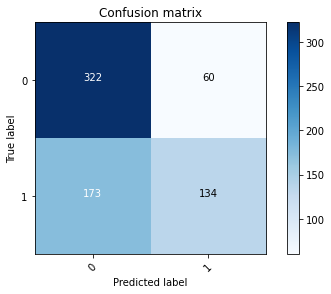

In [105]:
# Confusion matrix для Алгоритма 1
print('\nАлгоритм 1'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, df.pred1_classes), sorted(df.pred1_classes.unique()))

In [106]:
#df.loc[(df.target==0) & (df.target==df.pred1_classes)].shape[0] #TN
#df.loc[(df.target==1) & (df.target==df.pred1_classes)].shape[0] #TP
#tn, fp, fn, tp = confusion_matrix(df.target, df.pred1_classes).ravel()
#tn, fp, fn, tp


Алгоритм 2
---------------------------------------------


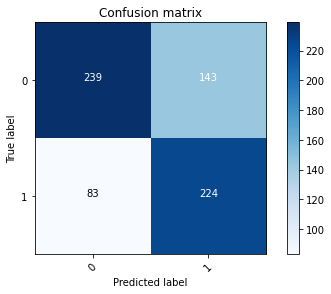

In [107]:
# Confusion matrix для Алгоритма 2
print('\nАлгоритм 2'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, df.pred2_classes), sorted(df.pred2_classes.unique()))


Алгоритм 3
---------------------------------------------


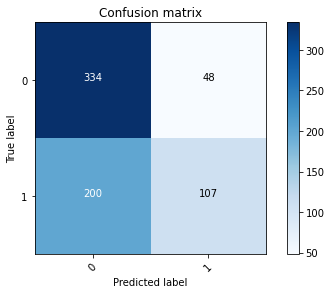

In [108]:
# Confusion matrix для Алгоритма 3
print('\nАлгоритм 3'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, df.pred3_classes), sorted(df.pred3_classes.unique()))

Давайте определимся с целями нашего предсказания:
    
* **Вариант 1**: хотим выдать кредит максимальному числу людей среди тех, кто мог бы его вернуть. При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того полнота должна быть как можно больше (число в левом нижнем квадрате матрицы ошибок минимально).

**Задание 5.** Для каждого алгоритма найдите такой порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной полноты можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65?

**Комментарий:** порог можно искать в цикле с небольшим шагом.

In [109]:
# Для каждого из 3-х алгоритмов подбираем порог с шагом 0.01 с целью добиться лучшей полноты при accuracy>=0.65 
fitted_results = []
for i in range(1,4):
    pred_col = 'pred'+str(i)+'_probs'
    result = []
    for th in np.arange(0,1,0.01):
        pred = (df[pred_col]>th).map(int)
        ac_sc = accuracy_score(df.target, pred)
        rec_sc = recall_score(df.target, pred)
        result.append((th, ac_sc, rec_sc))
        
        # Фильтруем по заданному минимальному уровню accuracy
    fitted_results.append([i for i in result if i[1]>=0.65])

In [110]:
# Сортируем полученные метрики 
for i in fitted_results:
    i.sort(reverse=True, key=lambda x: x[2])

In [111]:
# Берем лучшие значения. Если значений с требуемыми параметрами нет, то заполняем nan
best_estim = [i[0] if len(i)>0 else (np.nan, np.nan, np.nan) for i in fitted_results]

In [112]:
best_estim # (threshold, accuracy, recall)

[(0.36, 0.6516690856313497, 0.742671009771987),
 (0.27, 0.6748911465892597, 0.8371335504885994),
 (nan, nan, nan)]

**Задание 6.** Визуализируйте матрицу ошибок для каждого из трех алгоритмов с подобранным порогом.


Алгоритм 1 (оптимизированный по recall)
---------------------------------------------


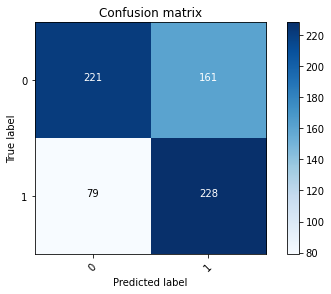

In [113]:
# Confusion matrix для Алгоритма 1 (Оптимизация по recall)
print('\nАлгоритм 1 (оптимизированный по recall)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred1_probs>best_estim[0][0]).map(int)), sorted(df.pred1_classes.unique()))


Алгоритм 2 (оптимизированный по recall)
---------------------------------------------


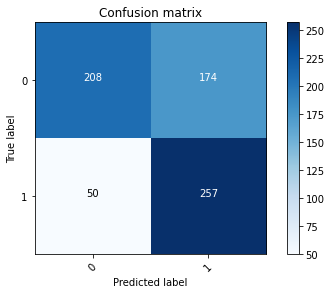

In [114]:
# Confusion matrix для Алгоритма 2 (Оптимизация по recall)
print('\nАлгоритм 2 (оптимизированный по recall)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred2_probs>best_estim[1][0]).map(int)), sorted(df.pred1_classes.unique()))

In [115]:
print('\nДля Алгоритма 3 не удалось подобрать порог, чтобы добиться accuracy>=0.65\n')


Для Алгоритма 3 не удалось подобрать порог, чтобы добиться accuracy>=0.65



**Выводы:** \
Лучше всего с задачей справился Алгоритм 2. Удалось получить recall на уроыне 0.83 при accuracy=0.67 с порогом **0.27**

Наша цель может звучать и по-другому:
    
* **Вариант 2**: среди тех, кому модель выдает кредит, должно быть меньше всего ошибок (мало людей, кто его на самом деле не вернет - на них будем терять деньги). 
    При этом не хотим много ошибаться (общее число ошибок не более 35%).
  
1) Мы не хотим, чтобы алгоритм много ошибался: accuracy $\geq$ 0.65.

2) Кроме того точность должна быть как можно больше (число в правом верхнем квадрате матрицы ошибок минимально).

**Задание 7.** Для каждого алгоритма найдите порог принятия решения, чтобы выполнялись перечисленные выше условия. Какой максимальной точности можно добиться у каждой из моделей при условии, что accuracy $\geq$ 0.65? 

In [116]:
# Для каждого из 3-х алгоритмов подбираем порог с шагом 0.01 с целью добиться лучшей точности при accuracy>=0.65 
fitted_results = []
for i in range(1,4):
    pred_col = 'pred'+str(i)+'_probs'
    result = []
    for th in np.arange(0,1,0.01):
        pred = (df[pred_col]>th).map(int)
        ac_sc = accuracy_score(df.target, pred)
        rec_sc = precision_score(df.target, pred, zero_division=0)
        result.append((th, ac_sc, rec_sc))
        
        # Фильтруем по заданному минимальному уровню accuracy
    fitted_results.append([i for i in result if i[1]>=0.65])

In [117]:
# Сортируем полученные метрики 
for i in fitted_results:
    i.sort(reverse=True, key=lambda x: x[2])

In [118]:
# Берем лучшие значения. Если значений с требуемыми параметрами нет, то заполняем nan
best_estim = [i[0] if len(i)>0 else (np.nan, np.nan, np.nan) for i in fitted_results]

In [119]:
best_estim # (threshold, accuracy, recall)

[(0.54, 0.6618287373004355, 0.7371794871794872),
 (0.73, 0.6502177068214804, 0.8367346938775511),
 (nan, nan, nan)]

**Задание 8.** Нарисуйте матрицы ошибок для каждого из алгоритмов с найденными значениями порога. Какая модель лучше всех справилась с этой задачей?


Алгоритм 1 (оптимизированный по precision)
---------------------------------------------


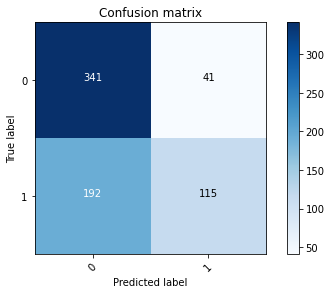

In [120]:
# Confusion matrix для Алгоритма 1 (Оптимизация по precision)
print('\nАлгоритм 1 (оптимизированный по precision)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred1_probs>best_estim[0][0]).map(int)), sorted(df.pred1_classes.unique()))


Алгоритм 2 (оптимизированный по precision)
---------------------------------------------


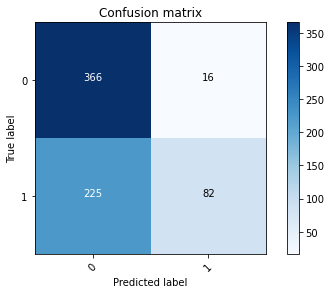

In [121]:
# Confusion matrix для Алгоритма 2 (Оптимизация по precision)
print('\nАлгоритм 2 (оптимизированный по precision)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred2_probs>best_estim[1][0]).map(int)), sorted(df.pred2_classes.unique()))

**Выводы:** \
Лучше всего с задачей снова справился Алгоритм 2. Удалось получить recall на уроыне 0.83 при accuracy=0.65 с порогом **0.73**

Также (**Вариант 3**) можно потребовать, чтобы и точность, и полнота были высокими, то есть обе ошибки в матрице ошибок были маленькие. Как вариант - можно максимизировать F1-score (среднее гармоническое между точностью и полнотой).

**Задание 9.** Найдите пороги для достижения максимального F1-score для каждой из трех моделей и нарисуйте матрицы ошибок. Какая модель решает поставленную задачу лучше остальных?

In [122]:
# Для каждого из 3-х алгоритмов подбираем порог с шагом 0.01 с целью добиться лучшего  f1_score при accuracy>=0.65 
fitted_results = []
for i in range(1,4):
    pred_col = 'pred'+str(i)+'_probs'
    result = []
    for th in np.arange(0,1,0.01):
        pred = (df[pred_col]>th).map(int)
        f1_sc = f1_score(df.target, pred)
        result.append((th, f1_sc))
        
        # Фильтруем по заданному минимальному уровню accuracy
    fitted_results.append(result)

In [123]:
# Сортируем полученные метрики 
for i in fitted_results:
    i.sort(reverse=True, key=lambda x: x[1])

In [124]:
# Берем лучшие значения
best_estim = [i[0] for i in fitted_results]

In [125]:
best_estim

[(0.34, 0.672), (0.32, 0.6990291262135923), (0.15, 0.6443418013856813)]


Алгоритм 1 (оптимизированный по f1_score)
---------------------------------------------


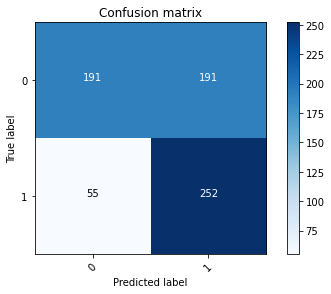

In [126]:
# Confusion matrix для Алгоритма 1 (Оптимизация по f1_score)
print('\nАлгоритм 1 (оптимизированный по f1_score)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred1_probs>best_estim[0][0]).map(int)), sorted(df.pred1_classes.unique()))


Алгоритм 2 (оптимизированный по f1_score)
---------------------------------------------


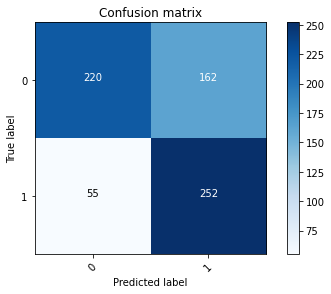

In [127]:
# Confusion matrix для Алгоритма 2 (Оптимизация по f1_score)
print('\nАлгоритм 2 (оптимизированный по f1_score)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred2_probs>best_estim[1][0]).map(int)), sorted(df.pred2_classes.unique()))


Алгоритм 3 (оптимизированный по f1_score)
---------------------------------------------


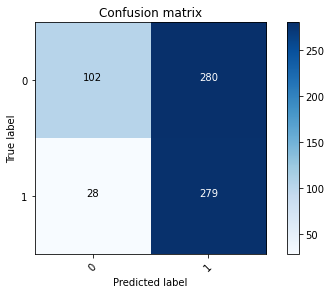

In [128]:
# Confusion matrix для Алгоритма 3 (Оптимизация по f1_score)
print('\nАлгоритм 3 (оптимизированный по f1_score)'+'\n'+'-'*45)
plot_confusion_matrix(confusion_matrix(df.target, (df.pred3_probs>best_estim[2][0]).map(int)), sorted(df.pred3_classes.unique()))

**Выводы:** \
Лучше всего с задачей снова справился Алгоритм 2. Удалось получить f1_score на уроыне 0.69 с порогом **0.32**

#### Кстати

В python есть удобная функция classification_report, которая выводит значения нескольких метрик.

In [129]:
from sklearn.metrics import classification_report

print(classification_report(df['target'],df['pred1_classes']))

              precision    recall  f1-score   support

           0       0.65      0.84      0.73       382
           1       0.69      0.44      0.53       307

    accuracy                           0.66       689
   macro avg       0.67      0.64      0.63       689
weighted avg       0.67      0.66      0.65       689



### Обучим свою модель для предсказания target.

**Задание 10.** Отнормируйте признаки в задаче и обучите логистическую регрессию предсказывать target.

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [131]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,target,pred1_probs,pred1_classes,pred2_probs,pred2_classes,pred3_probs,pred3_classes
0,1,22.08,11.46,2,4,4,1.585,0,0,0,...,2,100,1213,0,0.506772,1,0.610853,1,0.375494,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,...,2,160,1,0,0.358519,0,0.185941,0,0.200975,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,...,2,280,1,0,0.358753,0,0.523009,1,0.160465,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,...,2,0,1,1,0.408729,0,0.185941,0,0.357771,0
4,1,20.17,8.17,2,6,4,1.960,1,1,14,...,2,60,159,1,0.480904,0,0.526646,1,0.260169,0


In [132]:
# Удаляем колонки колонки с предсказаниями и классами данных предсказательных алгоритмов
df_c = df.copy().drop(columns=['pred1_probs', 'pred1_classes', 'pred2_probs', 'pred2_classes', 'pred3_probs', 'pred3_classes'])

In [133]:
# Разделяем признаки и таргет
X_ = df_c.drop(columns='target')
y = df_c.target

In [134]:
# Проверяем формы
X_.shape, y.shape

((689, 14), (689,))

In [135]:
# Разделяем на тренировочную и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)

In [136]:
# Проверяем формы
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((482, 14), (207, 14), (482,), (207,))

In [137]:
# Задаем скалер
scaler = StandardScaler()

In [138]:
# Расчет параметров скалера
scaler.fit(X_train)

StandardScaler()

In [139]:
# Нормализуем данные по параметрам скалера
X_train = scaler.transform(X_train)

In [140]:
# Возвращаем формат DataFrame
X_train = pd.DataFrame(data=X_train, columns=df_c.drop(columns='target').columns)

In [141]:
X_train[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.701612,0.925562,0.072608,0.550295,1.016070,1.664643,3.123125,0.943502,-0.893592,-0.560902,1.123793,0.252553,-0.519529,-0.250925
1,0.701612,-0.756706,1.566847,0.550295,0.177943,-0.360235,0.328821,-1.059881,1.119078,-0.104992,1.123793,0.252553,-0.028523,-0.200618
2,0.701612,0.245084,0.380525,0.550295,-0.380809,-0.360235,-0.623884,0.943502,-0.893592,-0.560902,1.123793,0.252553,1.438916,-0.250925
3,0.701612,-0.455581,-0.832161,0.550295,0.177943,0.145984,-0.586784,0.943502,-0.893592,-0.560902,-0.889844,0.252553,0.914432,-0.244237
4,0.701612,-0.497637,-0.779435,0.550295,-0.380809,-0.360235,-0.512586,-1.059881,-0.893592,-0.560902,-0.889844,0.252553,0.083069,-0.250925


In [142]:
# Инициализируем модель
model = LogisticRegression()

In [143]:
# Обучаем модель
model.fit(X_train, y_train)

LogisticRegression()

In [144]:
# Предсказания на тесте 
pred = model.predict(scaler.fit_transform(X_test))

In [145]:
# Считаем accuracy
accuracy_score(y_test, pred)

0.8599033816425121

**Задание 11.** Подберите порог для перевода предсказания в классы, чтобы максимизировать:
    а) точность 
    б) полноту 
    в) f1-score. 
Лучше ли логистическая регрессия справилась с задачей, чем три готовые модели, предсказания которых мы анализировали выше?

In [146]:
# Удаляем колонки колонки с предсказаниями и классами данных предсказательных алгоритмов
df_c = df.copy().drop(columns=['pred1_probs', 'pred1_classes', 'pred2_probs', 'pred2_classes', 'pred3_probs', 'pred3_classes'])

In [147]:
# Разделяем признаки и таргет
X_ = df_c.drop(columns='target')
y = df_c.target

In [148]:
# Проверяем формы
X_.shape, X_train.shape

((689, 14), (482, 14))

In [149]:
# Разделяем на тренировочную и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((482, 14), (207, 14), (482,), (207,))

In [150]:
# Инициализируем модель
model = LogisticRegression()

In [151]:
# Создаем Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])

In [152]:
# Обучаем модель
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [153]:
# Предсказания на тесте (вероятности) 
pred = pipe.predict_proba(X_test)

In [154]:
# Так как классификация бинарная, то нам достаточно знать веротяность 1го класса
prob_class1 = np.array([i[1] for i in pred])

In [155]:
accuracy_score(y_test, pred.argmax(axis=1))

0.8599033816425121

In [156]:
# Метрики для оптимизации
metrics = {'precision':precision_score, 'recall':recall_score, 'f1':f1_score}

In [157]:
# Подбираем значения порога для максимизации метрик качества. Ставим условие на accuracy>=0.85 (иначе p)
best_estim = []
for m in metrics:
    max_score = 0
    best_th = 0
    for th in np.arange(0,1,0.01):
        pred_class1 = np.where(prob_class1>th, 1, 0)
        score = metrics[m](y_test, pred_class1)
        ac_sc = accuracy_score(y_test, pred_class1)
        #print(score, max_score, ac_sc)
        if score>max_score and ac_sc>=0.85:
            max_score = score
            best_th = th
    best_estim.append((best_th, max_score))

In [158]:
best_estim

[(0.6900000000000001, 0.9166666666666666),
 (0.17, 0.9560439560439561),
 (0.37, 0.8730964467005076)]

In [159]:
print(f'accuracy = {accuracy_score(y_test, np.where(prob_class1>0.37, 1, 0))}')
print(f'recall = {recall_score(y_test, np.where(prob_class1>0.37, 1, 0))}')
print(f'precision = {precision_score(y_test, np.where(prob_class1>0.37, 1, 0))}')
print(f'f1_score = {f1_score(y_test, np.where(prob_class1>0.37, 1, 0))}')

accuracy = 0.8792270531400966
recall = 0.945054945054945
precision = 0.8113207547169812
f1_score = 0.8730964467005076


**Вывод:** \
Логистической регрессией добились лучшего качества чем у данных изначально алгоритмов. С порогом **0.37**. Accuracy и f1_score на уровне 0.87